In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

## Generic GA, Crossover and Mutation Strategies

#### Selection Strategies

In [2]:
# Selection Strategies
def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    selection_probs = [f/total_fitness for f in fitnesses]
    return random.choices(population, weights=selection_probs, k=2)  #  weighted selection of 2 individuals

def tournament_selection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(2):
        contenders_idx = np.random.choice(len(population), tournament_size, replace=False)
        contenders_fitnesses = [fitnesses[idx] for idx in contenders_idx]
        winner_idx = contenders_idx[np.argmax(contenders_fitnesses)]
        selected.append(population[winner_idx])
    return selected

#### Crossover Strategies

In [3]:
# General Crossover Strategies
def single_point_crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1)-1)
    offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2 = parent2[:crossover_point] + parent1[crossover_point:]
    return offspring1, offspring2

def uniform_crossover(parent1, parent2):
    offspring1, offspring2 = parent1.copy(), parent2.copy()
    for i in range(len(parent1)):
        if random.random() < 0.5:
            offspring1[i], offspring2[i] = offspring2[i], offspring1[i]
    return offspring1, offspring2


# for TSP
def ordered_crossover(parent1, parent2):
    size = min(len(parent1), len(parent2))
    start, end = sorted(random.sample(range(size), 2))

    def make_offspring(p1, p2):
        offspring = [None]*size
        offspring[start:end] = p1[start:end]
        p2_indices = [idx for idx, city in enumerate(p2) if city not in offspring[start:end]]
        offspring_indices = [idx for idx, city in enumerate(offspring) if city is None]
        for offspring_idx, p2_idx in zip(offspring_indices, p2_indices):
            offspring[offspring_idx] = p2[p2_idx]
        return offspring

    offspring1 = make_offspring(parent1, parent2)
    offspring2 = make_offspring(parent2, parent1)
    return offspring1, offspring2

# Partially Mapped Crossover
def pm_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    offspring1 = parent1[:]
    offspring2 = parent2[:]
    # Mapping from parent1 to parent2 and parent2 to parent1
    mapping1to2 = {}
    mapping2to1 = {}

    for i in range(start, end + 1):
        city1, city2 = offspring1[i], offspring2[i]
        offspring1[i], offspring2[i] = city2, city1
        mapping1to2[city1] = city2
        mapping2to1[city2] = city1
    # Repair offspring using the mappings
    for i in range(size):
        if not (start <= i <= end):
            while offspring1[i] in mapping2to1:
                offspring1[i] = mapping2to1[offspring1[i]]
            while offspring2[i] in mapping1to2:
                offspring2[i] = mapping1to2[offspring2[i]]
    return offspring1, offspring2

# Cycle Crossover
def cycle_crossover(parent1, parent2):
    size = len(parent1)
    offspring1, offspring2 = [-1]*size, [-1]*size
    cycle = 0
    while min(offspring1) == -1:
        if cycle % 2 == 0:
            indices = [i for i, x in enumerate(offspring1) if x == -1]
        else:
            indices = [i for i, x in enumerate(offspring2) if x == -1]
        start = indices[0]
        while True:
            offspring1[start] = parent1[start] if cycle % 2 == 0 else parent2[start]
            offspring2[start] = parent2[start] if cycle % 2 == 0 else parent1[start]
            start = parent1.index(parent2[start]) if cycle % 2 == 0 else parent2.index(parent1[start])
            if start == indices[0]:
                break
        cycle += 1
    return offspring1, offspring2

#### Mutation Strategies

In [4]:
# General Mutation Strategies
def bit_flip_mutation(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]



# For TSP
# Insertion Mutation
def insertion_mutation(individual, mutation_rate):
    if random.random() < mutation_rate:
        index1 = random.randint(0, len(individual) - 1)
        index2 = random.randint(0, len(individual) - 1)
        city = individual.pop(index1)
        individual.insert(index2, city)

# Inversion Mutation
def inversion_mutation(individual, mutation_rate):
    if random.random() < mutation_rate:
        index1, index2 = sorted(random.sample(range(len(individual)), 2))
        individual[index1:index2] = reversed(individual[index1:index2])

# Swap Mutation
def swap_mutation(individual, mutation_rate):
    for _ in range(len(individual)):
        if random.random() < mutation_rate:
            idx1, idx2 = random.sample(range(len(individual)), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

#### Generic GA Framework

In [5]:
class GeneticAlgorithm:
    def __init__(self, population_size=100, generations=100, crossover_rate=0.8, mutation_rate=0.01, selection_func=roulette_wheel_selection, crossover_func=single_point_crossover, mutation_func=bit_flip_mutation, fitness_func=None, verbose=True):
        self.fitness_func = fitness_func if fitness_func else self.evaluate_fitness
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.selection_func = selection_func
        self.crossover_func = crossover_func
        self.mutation_func = mutation_func
        self.population = self.initialize_population()
        self.verbose = verbose

    def initialize_population(self):
        pass

    def evaluate_fitness(self, individual):
        pass

    def run(self):
        best_fitness_history = []  # log the best fitness value at each generation
        average_fitness_history = []  # log the average fitness of the population at each generation

        for generation in range(self.generations):
            new_population = []
            fitnesses = [self.fitness_func(individual) for individual in self.population]


            best_fitness = max(fitnesses)
            average_fitness = np.mean(fitnesses)
            best_fitness_history.append(best_fitness)
            average_fitness_history.append(average_fitness)

            while len(new_population) < self.population_size:
                parent1, parent2 = self.selection_func(self.population, fitnesses)
                if random.random() < self.crossover_rate:
                    offspring1, offspring2 = self.crossover_func(parent1, parent2)
                else:
                    offspring1, offspring2 = parent1.copy(), parent2.copy()

                self.mutation_func(offspring1, self.mutation_rate)
                self.mutation_func(offspring2, self.mutation_rate)

                new_population.extend([offspring1, offspring2])

            self.population = new_population[:self.population_size]

        if self.verbose:
            # Plots
            plt.figure(figsize=(12, 6))

            # Subplot for the fitness evolution
            ax1 = plt.subplot(1, 2, 1)
            ax1.plot(best_fitness_history, label='Best Fitness')
            ax1.plot(average_fitness_history, label='Average Fitness', linestyle='--')
            ax1.set_xlabel('Generation')
            ax1.set_ylabel('Fitness')
            ax1.set_title('Fitness Evolution Over Generations')
            ax1.legend()

            # Subplot for the final generation's fitness distribution histogram
            ax2 = plt.subplot(1, 2, 2)
            ax2.hist(fitnesses, bins=20, alpha=0.75)
            ax2.set_xlabel('Fitness')
            ax2.set_ylabel('Frequency')
            ax2.set_title('Final Generation Fitness Distribution')

            # Show the plots
            plt.tight_layout()
            plt.show()


## Knapsack GA

In [6]:
# The Knapsack Problem

class KnapsackGA(GeneticAlgorithm):
    def __init__(self, items, max_weight, **kwargs):
        self.final_best_fitness = None
        self.items = items
        self.max_weight = max_weight
        super().__init__(**kwargs)

    def initialize_population(self):
        return [[random.randint(0, 1) for _ in range(len(self.items))] for _ in range(self.population_size)]

    def evaluate_fitness(self, individual):
        total_value, total_weight = 0, 0
        for gene, item in zip(individual, self.items):
            if gene == 1:
                total_value += item[0]
                total_weight += item[1]
        if total_weight > self.max_weight:
            return 0  # Apply a penalty for exceeding the weight limit
        return total_value

    def run(self):
        super().run()
        best_individual = max(self.population, key=self.fitness_func)
        best_fitness = self.fitness_func(best_individual)
        total_weight = sum(item[1] for gene, item in zip(best_individual, self.items) if gene == 1)
        """
        print(f"\nFinal Best Solution: {best_individual}")
        print(f"Final Best Fitness: {best_fitness}")
        print(f"Total Weight of Final Best Solution: {total_weight}")
        """
        self.final_best_fitness = best_fitness


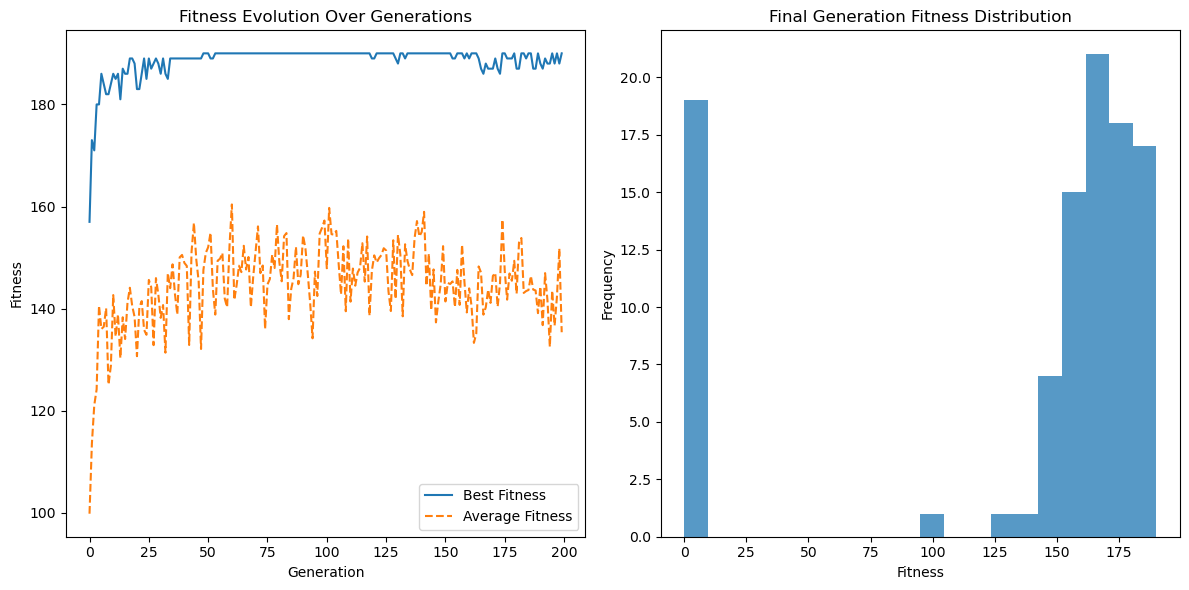

In [7]:
# Running the Knapsack GA

# Number of items
n_items = 20

# Generate items with incremental values and random weights between 1 and 10
items = [(i + 1, random.randint(1, 10)) for i in range(n_items)]

# Define the maximum weight of the knapsack
max_weight = 80

# Initialize the GA for the knapsack problem
knapsack_ga = KnapsackGA(
    items=items,
    max_weight=max_weight,
    population_size=100,
    generations=200,
    crossover_rate=1,
    mutation_rate=0.05,
    selection_func=tournament_selection,
    crossover_func=uniform_crossover,
    mutation_func=bit_flip_mutation,
)

# Run the GA
knapsack_ga.run()

## TSP GA

In [10]:
class TSPGA(GeneticAlgorithm):
    def __init__(self, cities, **kwargs):
        self.final_best_fitness = None
        self.cities = cities  # Store the cities as part of the TSPGA instance
        super().__init__(**kwargs)

    def initialize_population(self):
        # Each individual is a permutation of city indices
        return [random.sample(range(len(self.cities)), len(self.cities)) for _ in range(self.population_size)]

    def evaluate_fitness(self, individual):
        # In TSP, we aim to minimize the distance, so we can use the negative distance as fitness
        # This way, a shorter distance (higher negative) is considered 'fitter'
        return -self.calculate_total_distance(individual)

    def calculate_total_distance(self, path):
        distance = 0
        for i in range(len(path)):
            j = (i + 1) % len(path)
            city_a, city_b = self.cities[path[i]], self.cities[path[j]]
            distance += np.sqrt((city_a[0] - city_b[0])**2 + (city_a[1] - city_b[1])**2)
        return distance

    def run(self):
        super().run()
        best_individual = max(self.population, key=self.fitness_func)
        best_fitness = -self.fitness_func(best_individual)
        #"""
        print(f"\nFinal Best Path: {best_individual}")
        print(f"Final Shortest Distance: {best_fitness}")
        # Visualization of final solution
        plt.figure(figsize=(10, 6))
        for i in range(len(best_individual)):
            # Get the current city and the next city (with wrap-around)
            city_index = best_individual[i]
            next_city_index = best_individual[(i + 1) % len(best_individual)]
            current_city = self.cities[city_index]
            next_city = self.cities[next_city_index]

            # Plot a line between the current city and the next city
            plt.plot([current_city[0], next_city[0]], [current_city[1], next_city[1]], 'ro-')

        # Optionally, add annotations for cities
        for i, city in enumerate(self.cities):
            plt.text(city[0], city[1], str(i))

        plt.title(f'Best TSP Path (Fitness: {best_fitness})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.show()
        #"""
        self.final_best_fitness = best_fitness

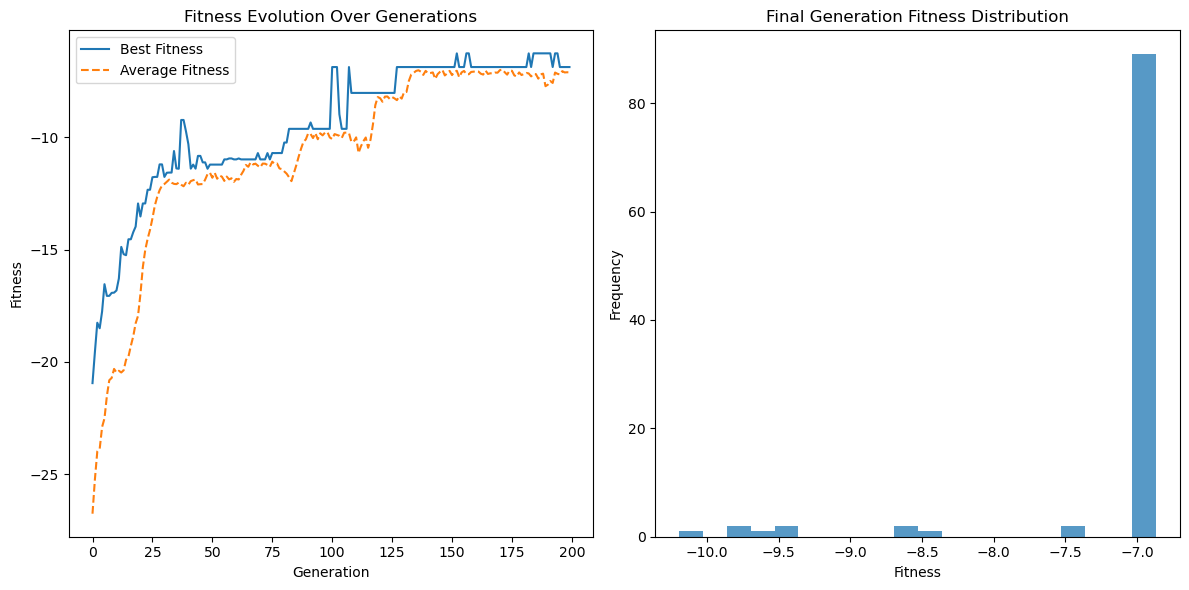


Final Best Path: [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 4]
Final Shortest Distance: 6.8677087189481005


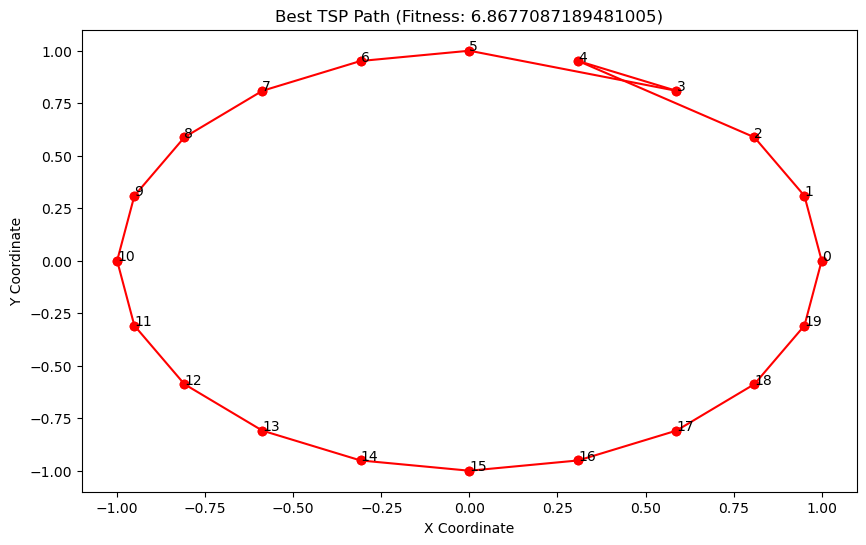

In [11]:
num_cities = 20
cities = [(np.cos(2 * np.pi / num_cities * i), np.sin(2 * np.pi / num_cities * i)) for i in range(num_cities)]

# Initialize the GA for the TSP problem
tsp_ga = TSPGA(
    cities = cities,
    population_size=100,
    generations=200,
    crossover_rate=1,
    mutation_rate=0.125,
    selection_func=tournament_selection,
    crossover_func=ordered_crossover,
    mutation_func=inversion_mutation,
)

tsp_ga.run()

## Experiments

#### Research Questions:
- Impact of Selection Strategy on GA Performance: How do the two selection strategies impact the efficiency and effectiveness in identifying high-quality solutions for both problems?
&nbsp;
- Crossover Strategy Efficiency: How does each strategy influence the algorithm's convergence rate and effectiveness in identifying high-quality solutions?
&nbsp;
- Mutation Rate Influence: How does altering the mutation rate affect the algorithm's performance in quality and convergence rate?
&nbsp;

#### 1. Impact of Selection Strategy:

In [48]:
# number of runs for each experiment
num_runs = 30

# Define the genetic algorithm parameters common to both experiments
population_size = 100
generations = 200
crossover_rate = 0.8
mutation_rate_knapsack = 0.05  # bit-flip mutation for knapsack
mutation_rate_tsp = 0.02  # inversion mutation for TSP

# Knapsack problem setup
max_weight = 80
n_items = 20
items = [(i + 1, random.randint(1, 10)) for i in range(n_items)]

# TSP problem setup
num_cities = 50
cities = [(np.cos(2 * np.pi / num_cities * i), np.sin(2 * np.pi / num_cities * i)) for i in range(num_cities)]


# Results dictionary to store the average performance metrics for each problem separately
results = {
    'knapsack': {
        'roulette_wheel_selection': {'average_best_fitness': 0, 'average_time': 0},
        'tournament_selection': {'average_best_fitness': 0, 'average_time': 0},
    },
    'tsp': {
        'roulette_wheel_selection': {'average_best_fitness': 0, 'average_time': 0},
        'tournament_selection': {'average_best_fitness': 0, 'average_time': 0},
    }
}

# Function to run the genetic algorithm with the specified selection strategy
def run_ga(selection_strategy, problem):
    if problem == 'knapsack':
        ga = KnapsackGA(
            items=items,
            max_weight=max_weight,
            population_size=population_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate_knapsack,
            selection_func=selection_strategy,
            crossover_func=uniform_crossover,
            mutation_func=bit_flip_mutation,
            verbose=False,  # off to suppress plots
        )
    elif problem == 'tsp':
        ga = TSPGA(
            cities=cities,
            population_size=population_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate_tsp,
            selection_func=selection_strategy,
            crossover_func=pm_crossover,
            mutation_func=inversion_mutation,
            verbose=False,  # off to suppress plots
        )
    start_time = time.time()
    ga.run()
    end_time = time.time()
    best_fitness = ga.final_best_fitness
    return best_fitness, end_time - start_time


# Run experiments for both problems and selection strategies
for problem in ['knapsack', 'tsp']:
    for selection_strategy in [roulette_wheel_selection, tournament_selection]:
        strategy_name = selection_strategy.__name__
        fitnesses = []
        times = []
        for _ in range(num_runs):
            best_fitness, run_time = run_ga(selection_strategy, problem)
            fitnesses.append(best_fitness)
            times.append(run_time)

        # Update results for the specific problem and selection strategy
        results[problem][strategy_name]['average_best_fitness'] = np.mean(fitnesses)
        results[problem][strategy_name]['average_time'] = np.mean(times)

# Print the results separately for each problem
for problem in ['knapsack', 'tsp']:
    print(f"Results for {problem}:")
    for strategy, metrics in results[problem].items():
        print(f"Strategy: {strategy}")
        print(f"Average Best Fitness: {metrics['average_best_fitness']}")
        print(f"Average Convergence Time: {metrics['average_time']}\n")

Results for knapsack:
Strategy: roulette_wheel_selection
Average Best Fitness: 182.13333333333333
Average Convergence Time: 0.3597585598627726

Strategy: tournament_selection
Average Best Fitness: 198.93333333333334
Average Convergence Time: 0.5437799215316772

Results for tsp:
Strategy: roulette_wheel_selection
Average Best Fitness: 54.96803623251416
Average Convergence Time: 1.9115089972813923

Strategy: tournament_selection
Average Best Fitness: 20.43712709735147
Average Convergence Time: 2.3083465178807576



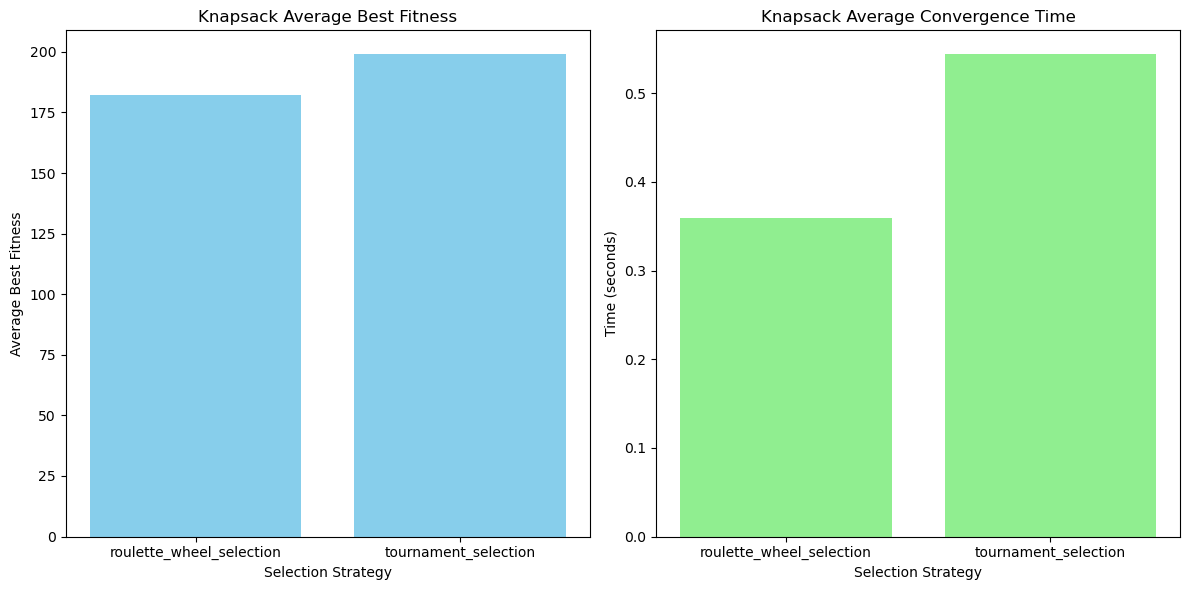

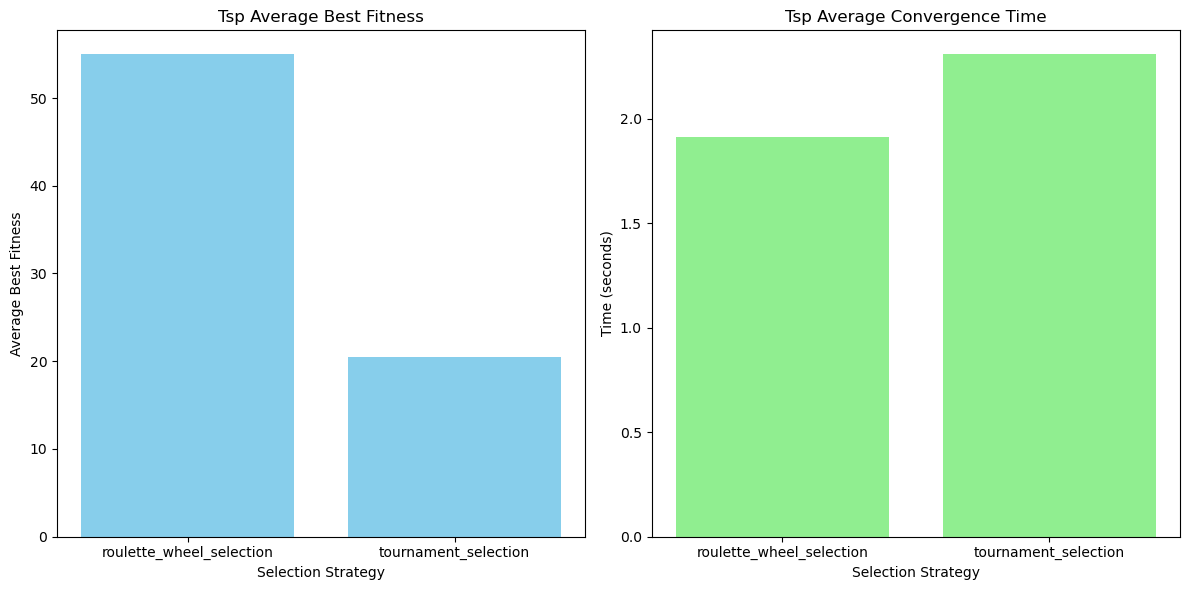

In [49]:
# Plot the results

for problem in ['knapsack', 'tsp']:
    plt.figure(figsize=(12, 6))

    # Bar chart for average best fitness
    plt.subplot(1, 2, 1)
    strategies = results[problem].keys()
    avg_fitnesses = [results[problem][strategy]['average_best_fitness'] for strategy in strategies]
    plt.bar(strategies, avg_fitnesses, color=['skyblue'])
    plt.title(f'{problem.capitalize()} Average Best Fitness')
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average Best Fitness')

    # Bar chart for average convergence time
    plt.subplot(1, 2, 2)
    avg_times = [results[problem][strategy]['average_time'] for strategy in strategies]
    plt.bar(strategies, avg_times, color=['lightgreen'])
    plt.title(f'{problem.capitalize()} Average Convergence Time')
    plt.xlabel('Selection Strategy')
    plt.ylabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

#### 2. Crossover Strategy Efficiency

In [50]:
# number of runs for each experiment
num_runs = 30

# Define the genetic algorithm parameters common to both experiments
population_size = 100
generations = 200
crossover_rate = 0.8
mutation_rate_knapsack = 0.05  # bit-flip mutation for knapsack
mutation_rate_tsp = 0.02  # inversion mutation for TSP

# Knapsack problem setup
max_weight = 80
n_items = 20
items = [(i + 1, random.randint(1, 10)) for i in range(n_items)]

# TSP problem setup
num_cities = 50
cities = [(np.cos(2 * np.pi / num_cities * i), np.sin(2 * np.pi / num_cities * i)) for i in range(num_cities)]

# Results dictionary to store the average performance metrics for each problem separately
results = {
    'knapsack': {
        'single_point_crossover': {'average_best_fitness': 0, 'average_time': 0},
        'uniform_crossover': {'average_best_fitness': 0, 'average_time': 0},
    },
    'tsp': {
        'ordered_crossover': {'average_best_fitness': 0, 'average_time': 0},
        'pm_crossover': {'average_best_fitness': 0, 'average_time': 0},
        'cycle_crossover': {'average_best_fitness': 0, 'average_time': 0},
    }
}

# Function to run the genetic algorithm with the specified selection strategy
def run_ga(crossover_func, problem):
    if problem == 'knapsack':
        ga = KnapsackGA(
            items=items,
            max_weight=max_weight,
            population_size=population_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate_knapsack,
            selection_func=tournament_selection,
            crossover_func=crossover_func,
            mutation_func=bit_flip_mutation,
            verbose=False,  # off to suppress plots
        )
    elif problem == 'tsp':
        ga = TSPGA(
            cities=cities,
            population_size=population_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate_tsp,
            selection_func=tournament_selection,
            crossover_func=crossover_func,
            mutation_func=inversion_mutation,
            verbose=False,  # off to suppress plots
        )
    start_time = time.time()
    ga.run()
    end_time = time.time()
    best_fitness = ga.final_best_fitness
    return best_fitness, end_time - start_time


# Crossover functions for the knapsack problem
knapsack_crossovers = {
    'single_point_crossover': single_point_crossover,
    'uniform_crossover': uniform_crossover,
}

# Crossover functions for the TSP problem
tsp_crossovers = {
    'ordered_crossover': ordered_crossover,
    'pm_crossover': pm_crossover,
    'cycle_crossover': cycle_crossover,
}

# Run experiments for Knapsack with each crossover strategy
for crossover_name, crossover_func in knapsack_crossovers.items():
    fitnesses = []
    times = []
    for _ in range(num_runs):
        best_fitness, run_time = run_ga(crossover_func, 'knapsack')
        fitnesses.append(best_fitness)
        times.append(run_time)
    results['knapsack'][crossover_name]['average_best_fitness'] = np.mean(fitnesses)
    results['knapsack'][crossover_name]['average_time'] = np.mean(times)

# Run experiments for TSP with each crossover strategy
for crossover_name, crossover_func in tsp_crossovers.items():
    fitnesses = []
    times = []
    for _ in range(num_runs):
        best_fitness, run_time = run_ga(crossover_func, 'tsp')
        fitnesses.append(best_fitness)
        times.append(run_time)
    results['tsp'][crossover_name]['average_best_fitness'] = np.mean(fitnesses)
    results['tsp'][crossover_name]['average_time'] = np.mean(times)

# Print the results
for problem, strategies in results.items():
    print(f"Results for {problem.capitalize()}:")
    for strategy, metrics in strategies.items():
        print(f"Strategy: {strategy}")
        print(f"Average Best Fitness: {metrics['average_best_fitness']:.2f}")
        print(f"Average Convergence Time: {metrics['average_time']:.2f} seconds\n")


Results for Knapsack:
Strategy: single_point_crossover
Average Best Fitness: 192.50
Average Convergence Time: 0.58 seconds

Strategy: uniform_crossover
Average Best Fitness: 192.23
Average Convergence Time: 0.57 seconds

Results for Tsp:
Strategy: ordered_crossover
Average Best Fitness: 16.12
Average Convergence Time: 2.56 seconds

Strategy: pm_crossover
Average Best Fitness: 21.04
Average Convergence Time: 2.48 seconds

Strategy: cycle_crossover
Average Best Fitness: 36.71
Average Convergence Time: 4.10 seconds



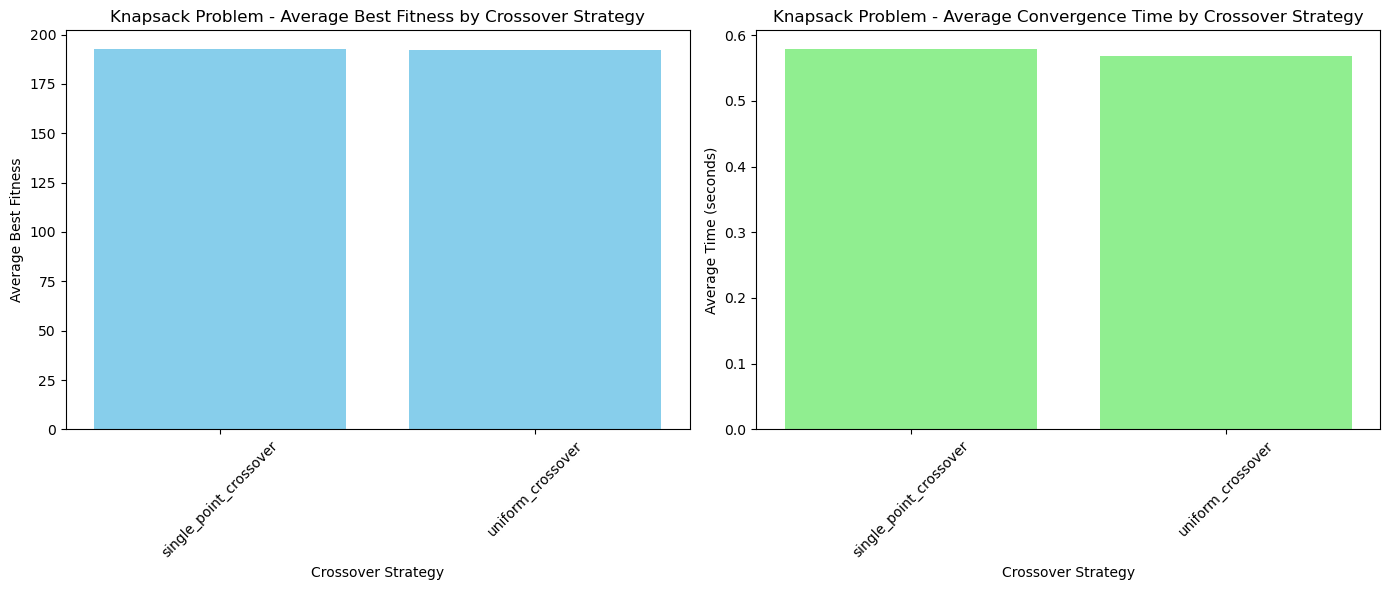

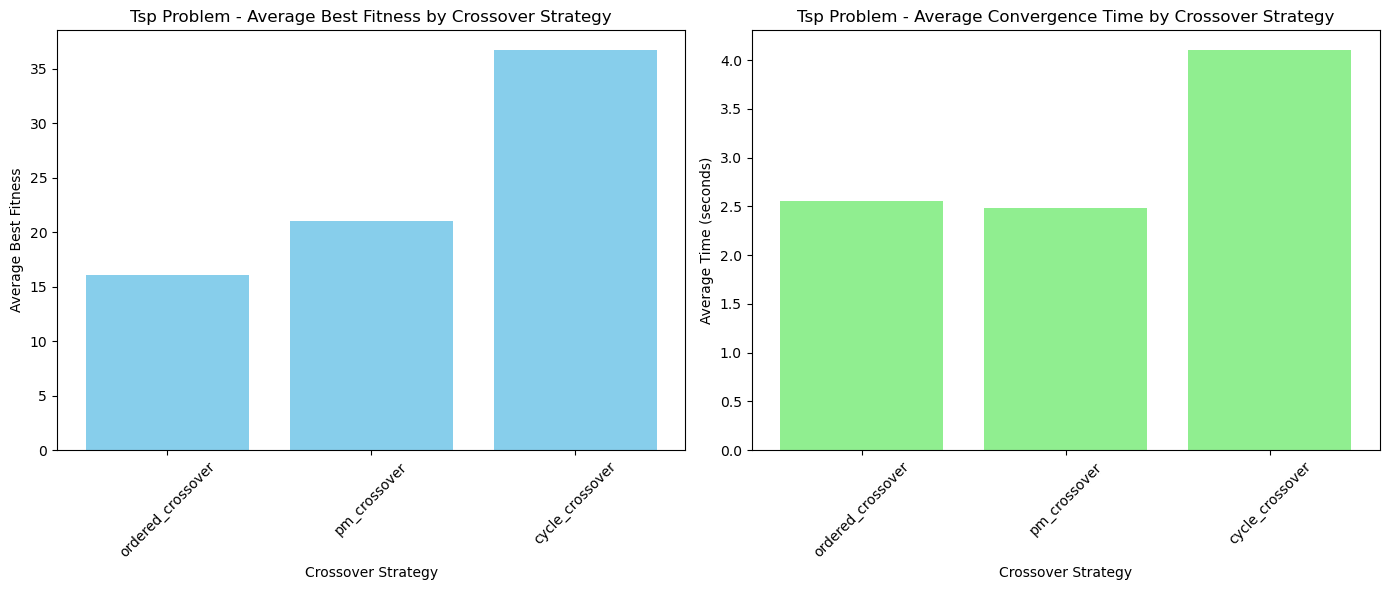

In [51]:
# Plot the results

for problem, strategies in results.items():
    plt.figure(figsize=(14, 6))

    # Extracting strategy names and their corresponding results for plotting
    strategy_names = list(strategies.keys())
    avg_fitnesses = [strategies[strategy]['average_best_fitness'] for strategy in strategy_names]
    avg_times = [strategies[strategy]['average_time'] for strategy in strategy_names]

    # Plotting Average Best Fitness for each crossover strategy
    plt.subplot(1, 2, 1)
    plt.bar(strategy_names, avg_fitnesses, color='skyblue')
    plt.title(f'{problem.capitalize()} Problem - Average Best Fitness by Crossover Strategy')
    plt.ylabel('Average Best Fitness')
    plt.xlabel('Crossover Strategy')
    plt.xticks(rotation=45)  # Rotate strategy names for better readability

    # Plotting Average Convergence Time for each crossover strategy
    plt.subplot(1, 2, 2)
    plt.bar(strategy_names, avg_times, color='lightgreen')
    plt.title(f'{problem.capitalize()} Problem - Average Convergence Time by Crossover Strategy')
    plt.ylabel('Average Time (seconds)')
    plt.xlabel('Crossover Strategy')
    plt.xticks(rotation=45)  # Rotate strategy names for better readability

    plt.tight_layout()
    plt.show()

#### 3. Mutation Rate Influence

In [53]:
# number of runs for each experiment
num_runs = 30

# Define the genetic algorithm parameters common to both experiments
population_size = 100
generations = 200
crossover_rate = 0.8
mutation_rates = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125]

# Knapsack problem setup
max_weight = 80
n_items = 20
items = [(i + 1, random.randint(1, 10)) for i in range(n_items)]

# TSP problem setup
num_cities = 50
cities = [(np.cos(2 * np.pi / num_cities * i), np.sin(2 * np.pi / num_cities * i)) for i in range(num_cities)]

# Results dictionary to store the average performance metrics for each problem separately
results = {
    'knapsack': {rate: {'average_best_fitness': 0, 'average_time': 0} for rate in mutation_rates},
    'tsp': {rate: {'average_best_fitness': 0, 'average_time': 0} for rate in mutation_rates},
}

# Function to run the genetic algorithm with the specified selection strategy
def run_ga(mutation_rate, problem):
    if problem == 'knapsack':
        ga = KnapsackGA(
            items=items,
            max_weight=max_weight,
            population_size=population_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate,
            selection_func=tournament_selection,
            crossover_func=uniform_crossover,
            mutation_func=bit_flip_mutation,
            verbose=False,  # off to suppress plots
        )
    elif problem == 'tsp':
        ga = TSPGA(
            cities=cities,
            population_size=population_size,
            generations=generations,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate,
            selection_func=tournament_selection,
            crossover_func=ordered_crossover,
            mutation_func=inversion_mutation,
            verbose=False,  # off to suppress plots
        )
    start_time = time.time()
    ga.run()
    end_time = time.time()
    best_fitness = ga.final_best_fitness
    return best_fitness, end_time - start_time

# Running the experiments
for problem in ['knapsack', 'tsp']:
    for mutation_rate in mutation_rates:
        fitnesses = []
        times = []
        for _ in range(num_runs):
            best_fitness, run_time = run_ga(mutation_rate, problem)
            fitnesses.append(best_fitness)
            times.append(run_time)
        results[problem][mutation_rate]['average_best_fitness'] = np.mean(fitnesses)
        results[problem][mutation_rate]['average_time'] = np.mean(times)

# Print the results
for problem, mutation_rates in results.items():
    print(f"Results for {problem.capitalize()} Problem:")
    for rate, metrics in mutation_rates.items():
        print(f"Mutation Rate: {rate}")
        print(f"Average Best Fitness: {metrics['average_best_fitness']:.2f}")
        print(f"Average Convergence Time: {metrics['average_time']:.2f} seconds\n")


Results for Knapsack Problem:
Mutation Rate: 0.01
Average Best Fitness: 202.87
Average Convergence Time: 0.71 seconds

Mutation Rate: 0.025
Average Best Fitness: 202.80
Average Convergence Time: 0.58 seconds

Mutation Rate: 0.05
Average Best Fitness: 202.83
Average Convergence Time: 0.63 seconds

Mutation Rate: 0.075
Average Best Fitness: 200.90
Average Convergence Time: 0.63 seconds

Mutation Rate: 0.1
Average Best Fitness: 196.50
Average Convergence Time: 0.61 seconds

Mutation Rate: 0.125
Average Best Fitness: 192.50
Average Convergence Time: 0.64 seconds

Results for Tsp Problem:
Mutation Rate: 0.01
Average Best Fitness: 18.70
Average Convergence Time: 2.58 seconds

Mutation Rate: 0.025
Average Best Fitness: 16.63
Average Convergence Time: 2.50 seconds

Mutation Rate: 0.05
Average Best Fitness: 14.02
Average Convergence Time: 2.38 seconds

Mutation Rate: 0.075
Average Best Fitness: 13.16
Average Convergence Time: 2.22 seconds

Mutation Rate: 0.1
Average Best Fitness: 12.72
Average 

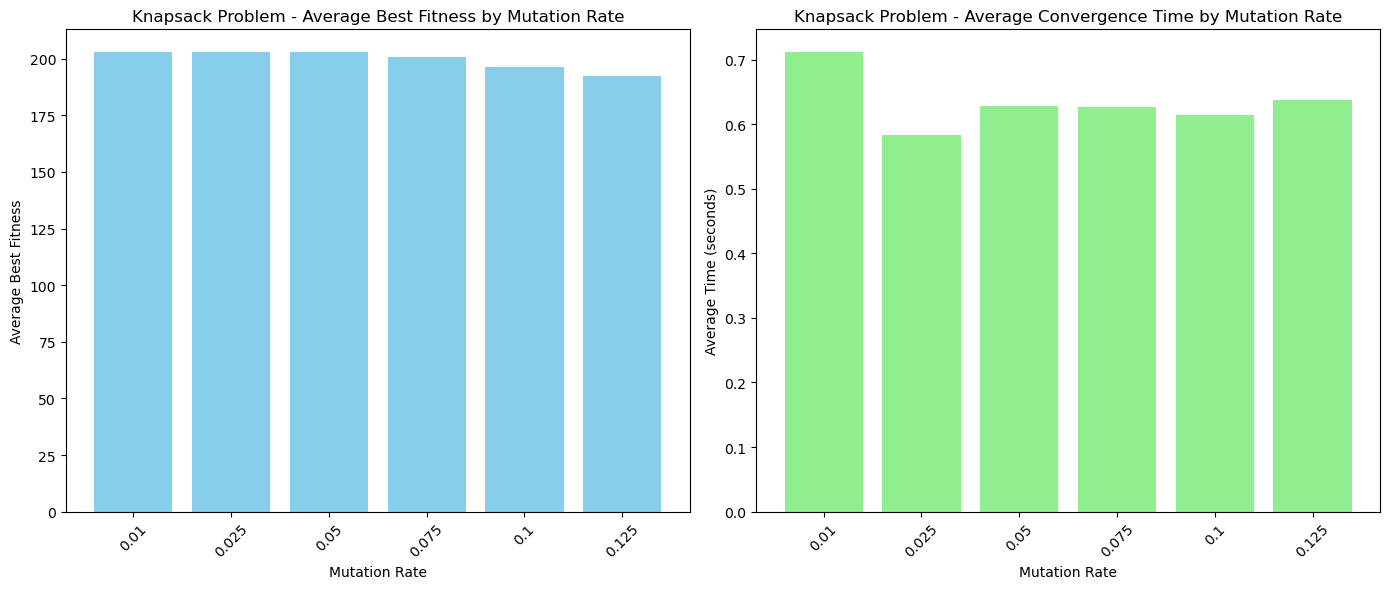

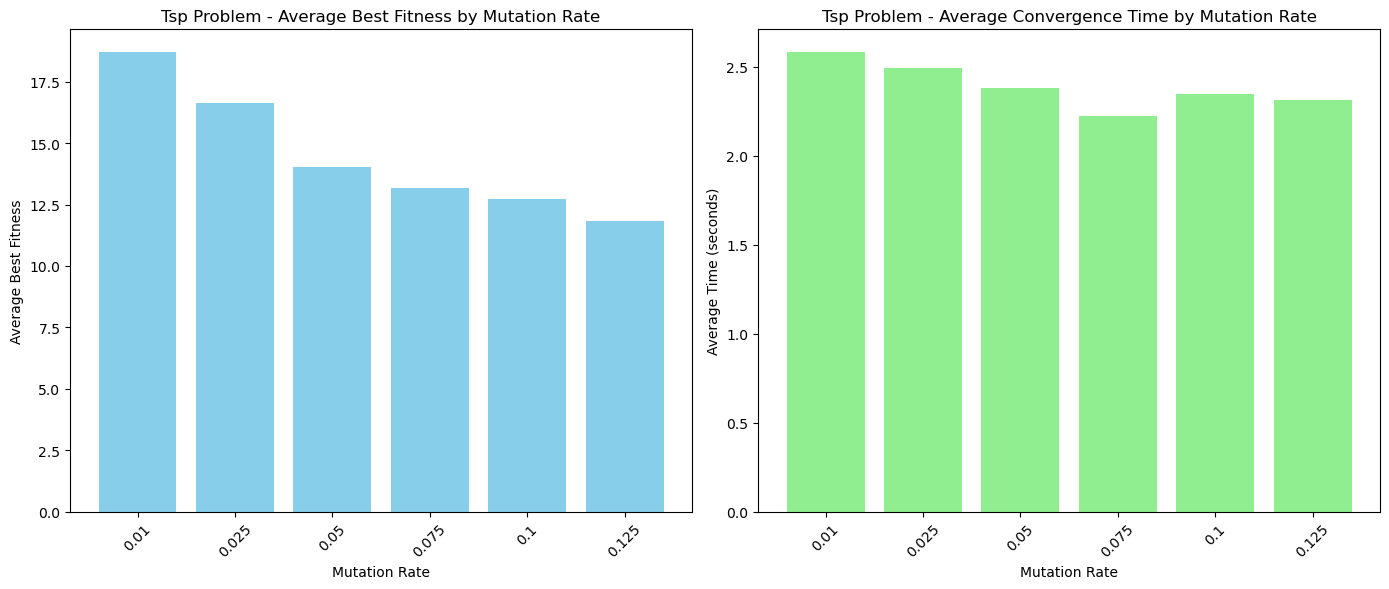

In [54]:
# Plot the results

for problem, mutation_rates in results.items():
    plt.figure(figsize=(14, 6))

    # Extracting mutation rate values and their corresponding results for plotting
    rates = list(mutation_rates.keys())
    avg_fitnesses = [mutation_rates[rate]['average_best_fitness'] for rate in rates]
    avg_times = [mutation_rates[rate]['average_time'] for rate in rates]

    # Plotting Average Best Fitness for each mutation rate
    plt.subplot(1, 2, 1)
    plt.bar([str(rate) for rate in rates], avg_fitnesses, color='skyblue')
    plt.title(f'{problem.capitalize()} Problem - Average Best Fitness by Mutation Rate')
    plt.ylabel('Average Best Fitness')
    plt.xlabel('Mutation Rate')
    plt.xticks(rotation=45)  # Rotate rate labels for better readability

    # Plotting Average Convergence Time for each mutation rate
    plt.subplot(1, 2, 2)
    plt.bar([str(rate) for rate in rates], avg_times, color='lightgreen')
    plt.title(f'{problem.capitalize()} Problem - Average Convergence Time by Mutation Rate')
    plt.ylabel('Average Time (seconds)')
    plt.xlabel('Mutation Rate')
    plt.xticks(rotation=45)  # Rotate rate labels for better readability

    plt.tight_layout()
    plt.show()
